In [1]:
import numpy as np
import pandas as pd
import scipy.linalg as la
import scipy.sparse as sparse
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

### Governing Equations

For the spatial domain $\Omega = [0,L] \subset \mathbb{R}$ and the time domain $[t_0,t_f] \subset \mathbb{R}$, consider the one-dimensional heat equation with homogeneous Dirichlet boundary conditions:

$$\frac{\partial}{\partial t} q(x,t) = \frac{\partial^2}{\partial x^2} q(x,t) \quad x \in \Omega, t \in (t_0,t_f],$$
$$q(0,t) = q(L,t) = 0 \quad t \in [t_0,t_f],$$
$$q(x,t_0) = q_0(x) \quad x \in \Omega$$

This is a model for a one-dimensional rod that conducts heat. The unknown state variable $q(x,t)$ represents the temperature of the rod at location $x$ and time $t$; the temperature at the ends of the rod are fixed at $0$ and heat is allowed to flow out of the rod at the ends.


### Objective

Construct a low-dimensional system of ordinary differential equations, called the *reduced-order model* (ROM), which can be solved rapidly to produce approximate solutions $q(x,t)$ to the partial differential equation given above. We will use operator inference (OpInf) to learn the ROM from high-fidelity data for one choice of initial condition $q_0(x)$ and test its performance on new initial conditions.

### Training Data

#### Define the Full-order Model

To solve the problem numerically, let $\{x\}_{i=0}^{n+1}$ be an equidistant grid of $n+2$ points on $\Omega$, i.e., 
$$0 = x_0 < x_1 < ... < x_n < x_{n+1} = L \quad \text{and} \quad \delta x = \frac{L}{n+1}=x_{i+1}-x_i, \quad i = 1,..., n-1.$$

The boundary conditions prescribe $q(x_0,t)=q(x_{n+1},t)=0$. Our goal is to compute $q(x,t)$ at the interiod spatial points $x_1,x_2,...,x_n$ for various $t=[0,T]$. We wish to compute the state vector
$${q}(t) = \begin{bmatrix}
           q(x_1,t) \\
           \vdots \\
           q(x_n,t)
         \end{bmatrix} \in \mathbb{R}^n$$
for $t \in [t_0, t_f]$. 

Introducing a central finite difference approximation for the spatial derivative,
$$ \frac{\partial^2}{\partial x^2}q(x,t) \approx \frac{q(x-\delta x,t) - 2q(x,t) + q(x+\delta x,t)}{(\delta x)^2},$$

yields the semi-discrete linear system
$$\frac{d}{dt}q(t) = Aq(t), \quad q(0) = q_0, $$
where
$$A = \frac{1}{(\delta x)^2} \begin{bmatrix}
               -2 & 1  \\
               1 & -2 & 1 \\
               & \ddots &   \ddots     & \ddots \\
                & & 1 & -2 & 1 \\
                & & & 1 & -2 \\
         \end{bmatrix} \in \mathbb{R}^{n \times n}, \quad q_0 = \begin{bmatrix}
           q(x_1,t) \\
           \vdots \\
           q(x_n,t)
         \end{bmatrix} \in \mathbb{R}^n$$

The semi-discrete linear system above is called the *full-order model* (FOM) or the *high-fidelity model*. The computational complexity of solving it depends on the dimension $n$, which must often be large in order for $q(t)$ to approximate $q(x,t)$ well over the spatial grid. Our goal is to construct a ROM that approximates the FOM, but whose computational complexity only depends on some smaller dimension $r \ll n$.

#### Important
One key advantage of OpInf is that, because it learns a ROM from data alone, direct access to the high-fidelity solver (the matrix $A$ in this case) is not required. In this tutorial, we explicitly construct the high-fidelity solver, but in practice, we only need the following:

 1. Solution outputs of a high-fidelity solver to learn from, and
 2. Some knowledge of the structure of the governing equations.

#### Solve the Full-order Model
For this demo, we’ll use $t_0 = 0$ and $L = t_f = 1$. We begin by simulating the full-order system described above with the initial condition
$$q_0(x)=x(1-x),$$
using a maximal time step size $\delta t = 10^{-3}$. This results in $k = 10^3 + 1 = 1001$ state snapshots (1000 time steps after the initial condition), which are organized as the *snapshot matrix* $Q \in \mathbb{R}^{n \times k}$, where the *j*th column is the solution trajectory at time $t_j$:

$$Q =  \begin{bmatrix}
               q_0 & \dots & q_{k-1}  \end{bmatrix}, \quad q_j := q(t_j) \in \mathbb{R}^n, \quad j = 0, ..., k-1.$$

Note that the initial condition $q_0$ is included as a column in the snapshot matrix.

In [2]:
# Construct the spatial domain.
L = 1                           # Spatial domain length.
n = 2**7 - 1                    # Spatial grid size.
x_all = np.linspace(0, L, n+2)  # Full spatial grid.
x = x_all[1:-1]                 # Interior spatial grid (where q is unknown).
dx = x[1] - x[0]                # Spatial resolution.

# Construct the temporal domain.
t0, tf = 0, 1                   # Initial and final time.
k = tf*1000 + 1                 # Temporal grid size.
t = np.linspace(t0, tf, k)      # Temporal grid.
dt = t[1] - t[0]                # Temporal resolution.

print(f"Spatial step size δx = {dx}")
print(f"Temporal step size δt = {dt}")

Spatial step size δx = 0.0078125
Temporal step size δt = 0.001


In [3]:
# Construct the full-order state matrix A.
diags = np.array([1,-2,1]) / (dx**2)
A = sparse.diags(diags, [-1,0,1], (n,n))

# Define the full-order model dx/dt = f(t,x),  x(0) = x0.
def fom(t, x):
    return A @ x

# Construct the initial condition for the training data.
q0 = x * (1 - x)

print(f"shape of A:\t{A.shape}")
print(f"shape of q0:\t{q0.shape}")

shape of A:	(127, 127)
shape of q0:	(127,)


In [4]:
# Compute snapshots by solving the full-order model with SciPy.
Q = solve_ivp(fom, [t0,tf], q0, t_eval=t, method="BDF", max_step=dt).y

print(f"shape of Q: {Q.shape}")

shape of Q: (127, 1001)


### Visualize Training Data

In [5]:
def plot_heat_data(Z, title, ax=None):
    """Visualize temperature data in space and time."""
    if ax is None:
        _, ax = plt.subplots(1, 1)

    # Plot a few snapshots over the spatial domain.
    sample_columns = [0, 2, 5, 10, 20, 40, 80, 160, 320]
    color = iter(plt.cm.viridis_r(np.linspace(.05, 1, len(sample_columns))))

    leftBC, rightBC = [0], [0]
    for j in sample_columns:
        q_all = np.concatenate([leftBC, Z[:,j], rightBC])
        ax.plot(x_all, q_all, color=next(color), label=fr"$q(x,t_{{{j}}})$")

    ax.set_xlim(x_all[0], x_all[-1])
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$q(x,t)$")
    ax.legend(loc=(1.05, .05))
    ax.set_title(title)

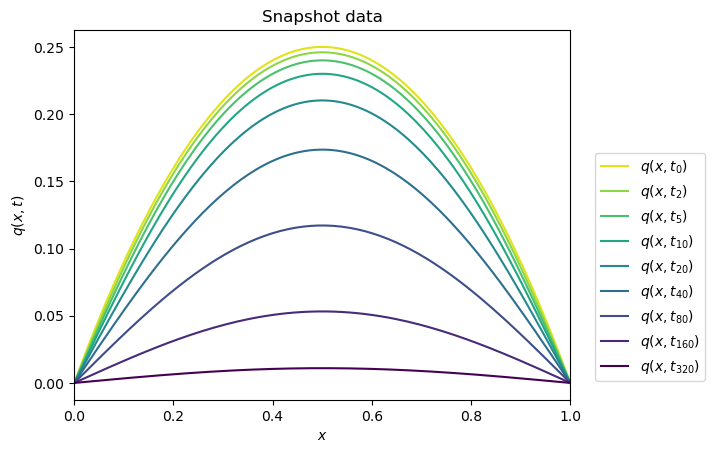

In [6]:
plot_heat_data(Q, "Snapshot data")

This matches our intuition: initially there is more heat toward the center of the rod, which then diffuses out of the ends of the rod. In the figure, earlier times are lighter colors and later times are darker colors.

At this point, we have gathered some training data by simulating the FOM. We also have an initial condition and space and time domains.

### Operator Inference

The FOM has the form as above,
$$\frac{d}{dt}q(t) = Aq(t), \quad q(0) = q_0,$$
with $q(t) \in \mathbb{R}^n$ and $A \in \mathbb{R}^{n \times n}$. Because Galerkin projection preserves the linear structure of the equations, we seek a ROM with a linear structure,

$$\frac{d}{dt}\hat{q}(t) = \hat{A}\hat{q}(t), \quad \hat{q}(0) = \hat{q}_0,$$
but with $\hat{q}(t) \in \mathbb{R}^r$ and $\hat{A} \in \mathbb{R}^{r \times r}$ for some $r \ll n$. The high-dimensional and low-dimensional states are related by $q(t) \approx V_r\hat{q}(t)$, where $V_r \in \mathbb{R}^{n \times r}$ is called the basis matrix. Operator inference constructs the above ROM by solving a low-dimensional data-driven minimization for $\hat{A}$,

$$\min_{\hat{A} \in \mathbb{R}^{r \times r}} \sum_{j=0}^{k-1} \lVert \hat{A}V_r^Tq_j - V_r^T\dot{q}_j \rVert_2^2 + \mathcal{R}(\hat{A}),$$

where $\dot{q}_j := \frac{d}{dt}q(t) \rvert_{t=t_j}$ is a measurement of the time derivative of $q(t)$ at time $t=t_j$, and $\mathcal{R}(\hat{A})$ is a regularization term to stabilize the learning problem. We often abbreviate this problem as 

$$\min_{\hat{A} \in \mathbb{R}^{r \times r}} \sum_{j=0}^{k-1} \lVert \hat{A}\hat{q}_j - \hat{\dot{q}}_j \rVert_2^2 + \mathcal{R}(\hat{A}),$$

where $\hat{q}_j=V_r^Tq_j$ and $\hat{\dot{q}}_j=V_r^T\dot{q_j}$ for $j = 0, ..., k-1$.

We have several tasks to consider:
1. Choosing the dimension $r$ of the ROM,
2. Constructing a low-dimensional subspace (computing $V_r$),
3. Compressing the state data to the low-dimensional subspace (computing $V_r^Tq_j, j = 0, ..., k-1)$,
4. Estimating the time derivatives of the state data (computing $V_r^T\dot{q}_j, j = 0, ..., k-1)$,
5. Constructing the ROM (above) via OpInf (from minimization),
6. Simulating the ROM, and
7. Evaluating the performance of the ROM.

We will do this all at once, then show each step in more detail.


In [7]:
import opinf

Vr, svdvals = opinf.basis.pod_basis(Q, r=2)              # Construct the low-dimensional basis.
Q_ = Vr.T @ Q                                            # Compress the state data to the low-dimensional subspace.
Qdot_ = opinf.ddt.ddt(Q_, dt, order=6)                   # Estimate the time derivatives of the compressed states.
rom = opinf.models.ContinuousModel("A")                  # Define the structure of the reduced-order model equations.
solver = opinf.lstsq.L2Solver(regularizer=1e-2)          # Select a least-squares solver with regularization.
rom.fit(Q_, Qdot_, solver=solver)                        # Use operator inference to calibrate the reduced-order model.
q0_ = Vr.T @ q0                                          # Compress the initial conditions to the low-dimensional subspace.
Q_ROM_ = rom.predict(q0_, t, method="BDF", max_step=dt)  # Solve the reduced-order model equations by integrating.
Q_ROM = Vr @ Q_ROM_                                      # Map the compressed solution back to the original state space.
opinf.post.frobenius_error(Q, Q_ROM)[1]                  # Compute the relative error of the ROM simulation.

/home/shoshi/mambaforge/envs/py38/lib/python3.8/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


0.0008697294695914612